<h1> DeepFake Face detection (Images Classification) project </h1>
<ol>
<h3>Notes:</h3>
<li>The validation and training data sets consists from shuffled real and fake images </li>
<li>The project questions 1-3 and 4 a-f are in a pdf</li>
<li>Training and Test sets folders are included</li>
<li>Some cells might take some time due to importing images and the azimuthal mean calculation</li>
<li>Pandas library is imported only to print the csv file quick look found at the bottom after running   
    DeepFakeDetection function
    (its more elegant than printing with cv2)</li>
</ol>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import glob
import pandas as pd
import random
%matplotlib inline

<h1><center>Functions</center></h1>
<h3>Future data functions</h3>
<h6>Ex.6 function included</h6>

In [2]:
def importIMGS(_dir):
    images = [cv.imread(file) for file in glob.glob(_dir)]
    
    fn = glob.glob(_dir)
    
    for i in range(len(images)):
        images[i] = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
    images1= np.array(images)
    return images1,fn

def Az_mean(images2):
    imgFourier = []
    F_amplitude = []

    #2D - DFT + shift DFT + 10E-8 addition
    for i in range(len(images2)):
        imgFourier.append( np.fft.fftshift(np.fft.fft2(images2[i])))
        for j in range(len(imgFourier)):
            imgFourier[j] += 10E-8
        F_amplitude.append(20 * np.log(abs(imgFourier[i])))
        amp = np.array(F_amplitude)
    return amp
def AzumithalPlot(n,images):
                        #DFT Amplitude Spectrum
                        #Azumithal Average calculation
    imgFourier = []
    F_amplitude = []
    
#2D - DFT + shift DFT + 10E-8 addition
    for i in range(len(images)):
        imgFourier.append( np.fft.fftshift(np.fft.fft2(images[i])))
        for j in range(len(imgFourier)):
            imgFourier[j] += 10E-8
        F_amplitude.append(20 * np.log(abs(imgFourier[i])))
        
    cen_x = 510
    cen_y = 512
    a = F_amplitude[n].shape[0]
    b = F_amplitude[n].shape[1]
    
# each point in the new grid will have the value corresponding
# to the radial distance from (510,512)

    [X,Y] = np.meshgrid(np.arange(b) - cen_x,np.arange(a) - cen_y)
    R = np.sqrt(np.square(X) + np.square(Y))
#rad will go from 1 to the max radial value in the grid 

    rad = np.arange(1,np.max(R),1)
    intensity = np.zeros(len(rad))
    idx = 0
# number of pixels included in addition, in short -> this will serve as a mask to the image
    binSize = 1
# loop over every radius while calculating the average intensity at each radius 
# and applying the calculated avg to intensity for every idx
    for i in rad:
        mask = (np.greater(R,i - binSize)) & np.less(R,i + binSize)
        values = F_amplitude[n][mask]
        intensity[idx] = np.mean(values)
        idx +=1
        
    return F_amplitude,rad,intensity
  
#Gradient descent
    
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def FaceDetectionGradientDescent(X, tar, learning_rate, iterations): 
    n = X.shape[0] 
    m = X.shape[1]
    W = np.zeros((n,1))
    cost_list = []
    for i in range(iterations):
        Z = np.dot(W.T,X) 
        S = sigmoid(Z)
        # cost function
        cost = -(1/m)*np.sum( tar*np.log(S) + (1-tar)*np.log(1-S))
        # Gradient Descent
        dW = (1/m)*np.dot(S-tar, X.T) 
        W = W - learning_rate*dW.T 
        # Keeping track of the cost history
        cost_list.append(cost) 
        if(i%(iterations/10) == 0):
            print("cost after ", i, "iterations is : ", cost)
    return W,cost_list    
 
    
# training,test and future data classification
    
    
def Classify(x,w,thresh):
    z = x@w
    p = sigmoid(z)
    #print(p)
#    print(p.shape)
    predictions = []
    for i in range(p.shape[0]):
        if p[i][1] > thresh:
            predictions.append(1)
        else:
            predictions.append(0)
    pr = np.array(predictions)
    return pr


def ConfusionMatrix(p,Tar):
    Conf_Mat = []
    TP = TN = FP = FN =0
    for i in range(len(Tar)):
        if p[i] == Tar[i][1] and Tar[i][1] == 1:
            TP += 1
        elif p[i] == Tar[i][1] and Tar[i][1] == 0:
            TN += 1
        elif p[i] == 1 and Tar[i][1] == 0:
            FP += 1
        elif p[i] == 0 and Tar[i][1] == 1:
            FN += 1
    return TP,FP,TN,FN

def accuracy(TP,FP,TN,FN):
    return (TP+TN)/(TP+TN+FP+FN)

def CrossEntropy(x,tar,w):
    ce = []
    for j in range(len(tar)):
        z = x@w
        p = sigmoid(z)
        cost = (tar[j][1]*np.log(p[j]) + (1-tar[j][1])*np.log(1-p[j]))
    ce.append(-np.mean(np.sum(cost)))
    return ce  

def ROC(Mat):
    TPR = (Mat[0])/(Mat[0]+Mat[3])
    FPR = (Mat[1])/(Mat[1]+Mat[2])
    return TPR,FPR

    
                                 # ex.6 func
def DeepFakeDetection(_dir,w):
    iterationsD = 90
    n = 10
    threshROC = np.linspace(0,1,n)
    thresh = 0.43
    ce_D = []
    ac_D = []
    D_TPR = []
    D_FPR = []
    intenD = []
    p = []
    file = "FutureDataEstimatedLabels.csv"
    
                                 #Import n images
        
    images,FileName = importIMGS(_dir)
    for i in range(len(images)):
        intenD.append(AzumithalPlot(i,images)[2])
        
                                 #Plots     
            
    fig,axes = plt.subplots(nrows = images.shape[0],ncols = 3,figsize = (14,14))
    axes[0][0].set_title("Greyscaled Images",fontweight = 'bold',fontsize = 18)
    axes[0][1].set_title("DFT",fontweight = 'bold',fontsize = 18)
    axes[0][2].set_title("Azimuthal Average",fontweight = 'bold',fontsize = 18)
    
    for j in range(len(images)):
        axes[j][0].imshow(images[j],cmap = "Greys_r")
        axes[j][1].imshow(AzumithalPlot(j,images)[0][j],cmap = 'Greys_r')
        axes[j][2].plot(AzumithalPlot(j,images)[1],AzumithalPlot(j,images)[2],linewidth = 1)
        axes[j][2].set_xlabel("Spatial Frequency",fontsize = 14)
        axes[j][2].set_ylabel("Power Spectrum",fontsize = 14)
    plt.show()
    
                                  #Sort data for classification
        
    X_F = np.array(intenD)
    x_Future = np.c_[np.ones(X_F.shape[0]),X_F]
    
                                  #Classification
    
    FuturePrediction = Classify(x_Future,w,thresh)
    
                                  #write to csv
        
    for k in range(len(FuturePrediction)):
        if FuturePrediction[k] == 1:
            p.append("Fake")
        elif FuturePrediction[k] == 0:
            p.append("Real")
            
    output = np.stack((FileName,p),axis =-1)
    np.savetxt(file,output,fmt = '%s',delimiter = ',', header = "Image Name, Classification")
    print("\033[1m"+"CSV file has been written successfully!\nLocation: in .ipynb directory")
    print("\nCSV File quick look:\n")
    
    opened = open(file, "r")
    readed = pd.read_csv(file)
    print(readed)

<h3>Training functions</h3>

In [3]:
def Az_mean(images2):
    imgFourier = []
    F_amplitude = []

    #2D - DFT + shift DFT + 10E-8 addition
    for i in range(len(images2)):
        imgFourier.append( np.fft.fftshift(np.fft.fft2(images2[i])))
        for j in range(len(imgFourier)):
            imgFourier[j] += 10E-8
        F_amplitude.append(20 * np.log(abs(imgFourier[i])))
        amp = np.array(F_amplitude)
    return amp
    
def av(n,amp):    
    cen_x = 510
    cen_y = 512
    l = 1 
    a = amp[n].shape[0]
    b = amp[n].shape[1]

    # each point in the new grid will have the value corresponding
    # to the radial distance from (510,512)
    #meshgrid makes a rectangular mesh out of x and y values of an array
    [X,Y] = np.meshgrid(np.arange(b) - cen_x,np.arange(a) - cen_y) 
    R = np.sqrt(np.square(X) + np.square(Y))

    #rad will go from 1 to the max radial value in the grid 722 in this case
    rad = np.arange(0,np.max(R),1)
    intensity = np.zeros((len(rad),l))
    #values = np.zeros((len(rad),l))
    idx = 0
    # number of pixels included in addition,
    #in short -> this is basically a mask to the image
    binSize = 1
    # loop over every radius while calculating the average intensity at each radius 
    # and applying the calculated avg to intensity for every idx
    for i in rad:
        mask = (np.greater(R,i - binSize)) & np.less(R,i + binSize)
        values = amp[n][mask]
        intensity[idx] = np.mean(values)
        idx +=1
    return intensity

def DeepFakeDetection2(_dir):
                                 #Import n images
            # no need to plot alot of images + it will take so long to calculate
    images = importIMGS(_dir)[0]
    for i in range(len(images)):
        Amp = np.array(AzumithalPlot(i,images)[0])
        
    return images,Amp    

In [4]:
# #                                 Training set #1
# intenT1 = []

# Ts1,Az_T1 = np.array(DeepFakeDetection2("TrainData/Training_Set_No.1/*.jpg"))

# for i in range(len(Ts1)):
#     intenT1.append(AzumithalPlot(i,Az_T1)[2])
# intensity1 = np.array(intenT1)
# xTrain1 = intensity1

In [5]:
#                      Training set #2 this will take some time
intenT2 = []

Ts2,Az_T2 = np.array(DeepFakeDetection2("TrainData/Training_Set_No.2/*.jpg"))


for i in range(len(Ts2)):
    intenT2.append(AzumithalPlot(i,Az_T2)[2])
intensity2 = np.array(intenT2)
xTrain2 = intensity2

In [6]:
xTrain2.shape

(21, 724)

In [7]:
# #                                 Training set #3
# intenT3 = []

# Ts3,Az_T3 = np.array(DeepFakeDetection2("TrainData/Training_Set_No.3/*.jpg"))

# for i in range(len(Ts3)):
#     intenT3.append(AzumithalPlot(i,Az_T3)[2])
# intensity3 = np.array(intenT3)
# xTrain3 = intensity3

In [8]:
# xTrain3.shape

In [9]:
#Target arrays for training sets
                               #Fake = 1, Real = 0 
    
#yTrainSet1 = np.array([0.0,1.0,0.0,1.0])

yTrainSet2 = np.array([1.0,0.0,0.0,0.0,1.0,
                       1.0,1.0,0.0,0.0,1.0,
                       0.0,1.0,0.0,1.0,0.0,
                       1.0,1.0,1.0,0.0,1.0,
                       1.0])

# yTrainSet3 = np.array([0.0,1.0,0.0,0.0,0.0,
#                        1.0,0.0,0.0,0.0,1.0,
#                        1.0,0.0,1.0,0.0,1.0,
#                        0.0,1.0,0.0,1.0,0.0,
#                        0.0,0.0,1.0,0.0,0.0,
#                        0.0,0.0,0.0,0.0,0.0,
#                        1.0,0.0])


# print("yTrain Set #1: {}".format(yTrainSet1.shape[0]))
print("yTrain Set #2: {}".format(yTrainSet2.shape[0]))
# print("yTrain Set #3: {}".format(yTrainSet3.shape[0]))

yTrain Set #2: 21


In [10]:
#xTrainNew1 = np.c_[np.ones(xTrain1.shape[0]),xTrain1]
xTrainNew2 = np.c_[np.ones(xTrain2.shape[0]),xTrain2]
#xTrainNew3 = np.c_[np.ones(xTrain3.shape[0]),xTrain3]

# yNew1 = np.c_[np.ones(yTrainSet1.shape[0]),yTrainSet1]
yNew2 = np.c_[np.ones(yTrainSet2.shape[0]),yTrainSet2]
# yNew3 = np.c_[np.ones(yTrainSet3.shape[0]),yTrainSet3]

print(xTrainNew2.shape)
print(yNew2.shape)

(21, 725)
(21, 2)


# Validation

In [11]:
#                                  Validation set #1
intenV1 = []

TsV1,Az_TV1 = np.array(DeepFakeDetection2("TrainData/Validation_Set_No.1/*.jpg"))

for i in range(len(TsV1)):
    intenV1.append(AzumithalPlot(i,Az_TV1)[2])
intensityV1 = np.array(intenV1)
xV1 = intensityV1

In [12]:
xV1.shape

(15, 724)

In [13]:
# #                                 Validation set #2
# intenV2 = []

# TsV2_images,Az_TV2 = DeepFakeDetection2("TrainData/Validation_Set_No.2/*.jpg")

# for i in range(len(TsV2_images)):
#     inten.append(AzumithalPlot(i,Az_TV1)[2])
# intensityV2 = np.array(inten)
# xV2 = intensityV2

In [14]:
# xV2.shape

In [15]:
# #Target arrays for Validation sets
#                                #Fake = 1, Real = 0 
xValidationNew1 = np.c_[np.ones(xV1.shape[0]),xV1]
# xValidationNew2 = np.c_[np.ones(xV2.shape[0]),xV2]

yValidationSet1 = np.array([1.0,1.0,1.0,0.0,1.0,
                            0.0,0.0,0.0,1.0,1.0,
                            1.0,1.0,1.0,1.0,1.0])

yValidationSet1 = np.c_[np.ones(yValidationSet1.shape[0]),yValidationSet1]
# yValidationSet2 = np.c_[np.ones(yValidationSet2.shape[0]),yValidationSet2]

<h1>Gradient Descent</h1>
<h3>Find and update weights</h3>

In [16]:
iterations1 = np.linspace(500,2000,10,dtype = int)
learning_rate = 0.0000001
W1 = []
CE1= []
ac1 = []
W = 0

In [17]:
for u in range(len(iterations1)):
    W1.append(FaceDetectionGradientDescent(xTrainNew2.T, yNew2.T ,learning_rate, iterations1[u])[0])

cost after  0 iterations is :  1.3862943611198904
cost after  50 iterations is :  0.6911559358572705
cost after  100 iterations is :  0.6867886723044184
cost after  150 iterations is :  0.685232462640086
cost after  200 iterations is :  0.6843865398387212
cost after  250 iterations is :  0.6838260482670627
cost after  300 iterations is :  0.683408681912487
cost after  350 iterations is :  0.6830732789804028
cost after  400 iterations is :  0.6827892003755645
cost after  450 iterations is :  0.6825394009690591
cost after  0 iterations is :  1.3862943611198904
cost after  0 iterations is :  1.3862943611198904
cost after  0 iterations is :  1.3862943611198904
cost after  100 iterations is :  0.6867886723044184
cost after  200 iterations is :  0.6843865398387212
cost after  300 iterations is :  0.683408681912487
cost after  400 iterations is :  0.6827892003755645
cost after  500 iterations is :  0.682313642979253
cost after  600 iterations is :  0.6819103403997286
cost after  700 iteration

cost after  0 iterations is :  1.3862943611198904
cost after  200 iterations is :  0.6843865398387212
cost after  400 iterations is :  0.6827892003755645
cost after  600 iterations is :  0.6819103403997286
cost after  800 iterations is :  0.6812128153145639
cost after  1000 iterations is :  0.6805888495102221
cost after  1200 iterations is :  0.680002463406639
cost after  1400 iterations is :  0.679438220414995
cost after  1600 iterations is :  0.6788883942617874
cost after  1800 iterations is :  0.6783486875091858


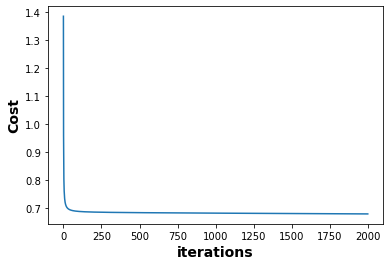


W shape: (725, 2)


In [18]:
iterations2 = 2000
learning_rate = 0.0000001

W,cost = FaceDetectionGradientDescent(xTrainNew2.T, yNew2.T ,learning_rate, iterations2)

plt.plot(cost)
plt.ylabel("Cost",fontweight = "bold",fontsize = 14)
plt.xlabel("iterations",fontweight = "bold",fontsize = 14)
plt.show()
print("\nW shape: {}".format(W.shape))

# Testing

In [19]:
                                            '''Testing Data set'''
Dir = "TrainData/Testing_Set_No.1/*.jpg"
TestImages,Az_T = np.array(DeepFakeDetection2(Dir))

In [20]:
yTest = np.array([1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0])
print(yTest.shape)
yTest = np.c_[np.ones(yTest.shape[0]),yTest]

(9,)


In [21]:
intenT = []

for i in range(len(TestImages)):
    intenT.append(AzumithalPlot(i,Az_T)[2])
intensityT = np.array(intenT)
x_test = intensityT

In [22]:
xTest = np.c_[np.ones(x_test.shape[0]),x_test]

In [23]:
xTest.shape

(9, 725)

<h2>Classification</h2>
<h3>Training</h3>

In [24]:
iterationsC = 300
n = 200
threshROC = np.linspace(0,1,n)
threshT =  0.569
ce = []
ac = []
Train_TPR = []
Train_FPR = []

In [25]:
TrainPrediction = Classify(xTrainNew2,W1[8],threshT)
Train_Mat = ConfusionMatrix(Classify(xTrainNew2,W1[8],threshT),yNew2)

In [26]:
print(TrainPrediction)
print(Train_Mat)

[1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1]
(12, 5, 4, 0)


In [27]:
for j in range(len(threshROC)):
    TrainMat = ConfusionMatrix(Classify(xTrainNew2,W1[8],threshROC[j]),yNew2)
    TPR,FPR = ROC(TrainMat)
    Train_TPR.append(TPR)
    Train_FPR.append(FPR)

for i in range(len(W1)):
    Train_Mat = ConfusionMatrix(Classify(xTrainNew2,W1[i],threshT),yNew2)
    ce.append(CrossEntropy(xTrainNew2,yNew2,W1[i]))
    ac.append(accuracy(Train_Mat[0],Train_Mat[1],Train_Mat[2],Train_Mat[3]))        

In [28]:
print("Average Model Accuracy: {:.2f}%".format(np.mean(ac)*100))

Average Model Accuracy: 70.00%


<table>
<thead>  
 <h6><center>Train</center></h6>
<tr><th>Threshold</th><th>Confusion Matrix</th>
</thead>
<tbody>
<tr><td>Thresh</td><td>TP,FP,TN,FN</td></tr>
<tr><td>0.1</td><td>(12, 9, 0, 0)</td></tr>
<tr><td><mark>0.569</mark></td><td><mark>(12, 5, 4, 0)</mark></td></tr>
<tr><td>0.6</td><td>(0, 0, 9, 12)</td></tr>
</tbody>
</table>

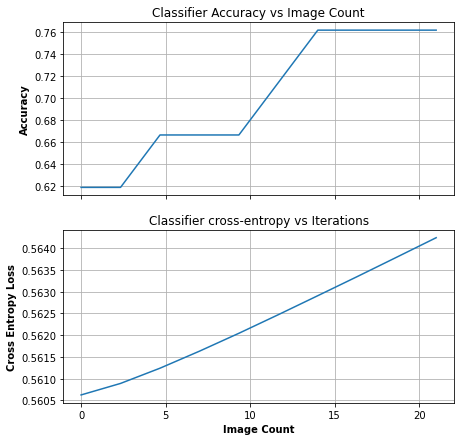

In [29]:
linspace1 = np.linspace(0,len(Ts2),len(W1))
fig, axes = plt.subplots(nrows = 2,ncols = 1,figsize = (7,7),sharex = True)
axes[0].plot(linspace1,ac)
axes[0].set_title("Classifier Accuracy vs Image Count")
axes[0].set_ylabel("Accuracy",fontweight = "bold")
axes[0].grid()

axes[1].plot(linspace1,ce)
axes[1].set_title("Classifier cross-entropy vs Iterations")
axes[1].set_xlabel("Image Count",fontweight = "bold")
axes[1].set_ylabel("Cross Entropy Loss",fontweight = "bold")
axes[1].grid()
plt.show()

<h3>Validation</h3>

In [30]:
CE_V = []
AC_V = []
Validation_TPR = []
Validation_FPR = []

In [31]:
ValPrediction = Classify(xValidationNew1,W1[8],threshT)
Val_Mat = ConfusionMatrix(Classify(xValidationNew1,W1[8],threshT),yValidationSet1)

In [32]:
print(ValPrediction)
print(Val_Mat)

[1 1 0 0 1 0 0 0 0 1 1 1 1 1 1]
(9, 0, 4, 2)


In [33]:
for j in range(len(threshROC)):
    Val_Mat = ConfusionMatrix(Classify(xValidationNew1,W1[8],threshROC[j]),yValidationSet1)
    TPR,FPR = ROC(Val_Mat)
    Validation_TPR.append(TPR)
    Validation_FPR.append(FPR)
i = 0
for i in range(len(W1)):
    Val_Mat = ConfusionMatrix(Classify(xValidationNew1,W1[i],threshT),yValidationSet1)
    CE_V.append(CrossEntropy(xValidationNew1,yValidationSet1,W1[i]))
    AC_V.append(accuracy(Val_Mat[0],Val_Mat[1],Val_Mat[2],Val_Mat[3]))        

In [34]:
print("Average Model Accuracy: {:.2f}%".format(np.mean(AC_V)*100))

Average Model Accuracy: 83.33%


<table>
<thead>  
 <h6><center>Validation</center></h6>
<tr><th>Threshold</th><th>Confusion Matrix</th>
</thead>
<tbody>
<tr><td>Thresh</td><td>TP,FP,TN,FN</td></tr>
<tr><td>0.1</td><td>(10, 5, 0, 0)</td></tr>
<tr><td><mark>0.569</mark></td><td><mark>(9, 0, 4, 2)</mark></td></tr>
<tr><td>0.6</td><td>(0, 0, 5, 10)</td></tr>
</tbody>
</table>

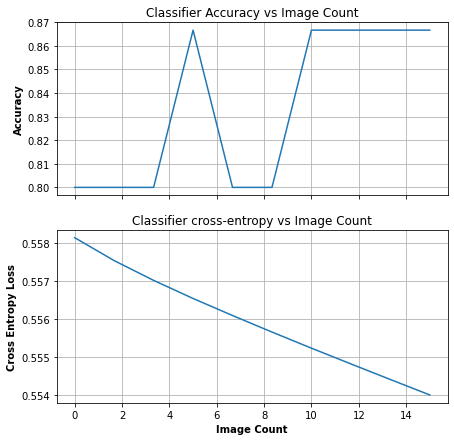

In [35]:
linspace2 = np.linspace(0,len(TsV1),len(W1))
fig, axes = plt.subplots(nrows = 2,ncols = 1,figsize = (7,7),sharex = True)
axes[0].plot(linspace2,AC_V)
axes[0].set_title("Classifier Accuracy vs Image Count")
axes[0].set_ylabel("Accuracy",fontweight = "bold")
axes[0].grid()

axes[1].plot(linspace2,CE_V)
axes[1].set_title("Classifier cross-entropy vs Image Count")
axes[1].set_xlabel("Image Count",fontweight = "bold")
axes[1].set_ylabel("Cross Entropy Loss",fontweight = "bold")
axes[1].grid()
plt.show()

<h3>Testing</h3>

In [36]:
CE = []
AC = []
Test_TPR = []
Test_FPR = []

In [37]:
TestPrediction = Classify(xTest,W1[8],threshT)
Test_Mat = ConfusionMatrix(Classify(xTest,W1[8],threshT),yTest)

In [38]:
print(TestPrediction)
print(Test_Mat)

[1 0 0 1 0 0 0 1 0]
(2, 1, 2, 4)


In [39]:
for j in range(len(threshROC)):
    Test_Mat = ConfusionMatrix(Classify(xTest,W1[8],threshROC[j]),yTest)
    TPR,FPR = ROC(Test_Mat)
    Test_TPR.append(TPR)
    Test_FPR.append(FPR)
i = 0
for i in range(len(W1)):
    Test_Mat = ConfusionMatrix(Classify(xTest,W1[i],threshT),yTest)
    CE.append(CrossEntropy(xTest,yTest,W1[i]))
    AC.append(accuracy(Test_Mat[0],Test_Mat[1],Test_Mat[2],Test_Mat[3]))        

In [40]:
print("Average Model Accuracy: {:.2f}%".format(np.mean(AC)*100))

Average Model Accuracy: 60.00%


<table>
<thead>  
 <h6><center>Test</center></h6>
<tr><th>Threshold</th><th>Confusion Matrix</th>
</thead>
<tbody>
<tr><td>Thresh</td><td>TP,FP,TN,FN</td></tr>
<tr><td>0.1</td><td>(5, 4, 0, 0)</td></tr>
<tr><td><mark>0.569</mark></td><td><mark>(2, 1, 2, 4)</mark></td></tr>
<tr><td>0.6</td><td>(0, 0, 4, 5)</td></tr>
</tbody>
</table>

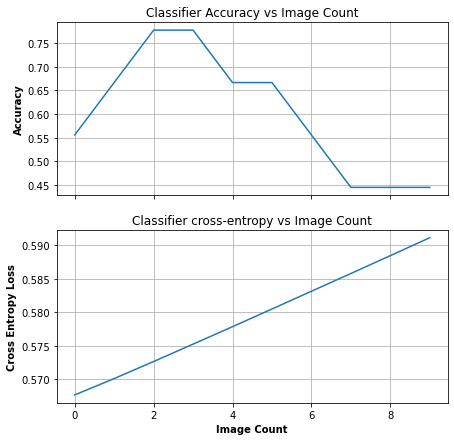

In [41]:
linspace3 = np.linspace(0,len(TestImages),len(W1))
fig, axes = plt.subplots(nrows = 2,ncols = 1,figsize = (7,7),sharex = True)
axes[0].plot(linspace3,AC)
axes[0].set_title("Classifier Accuracy vs Image Count")
axes[0].set_ylabel("Accuracy",fontweight = "bold")
axes[0].grid()

axes[1].plot(linspace3,CE)
axes[1].set_title("Classifier cross-entropy vs Image Count")
axes[1].set_xlabel("Image Count",fontweight = "bold")
axes[1].set_ylabel("Cross Entropy Loss",fontweight = "bold")
axes[1].grid()
plt.show()

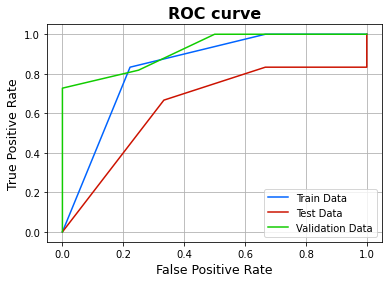

In [42]:
plt.plot(Train_FPR,Train_TPR,'#0064ff',label = "Train Data")
plt.plot(Test_FPR,Test_TPR,'#cc1200',label = "Test Data")
plt.plot(Validation_FPR,Validation_TPR,'#11cc00',label = "Validation Data")
plt.title("ROC curve", fontsize = 16,fontweight='bold')
plt.ylabel("True Positive Rate",fontsize = 12.5)
plt.xlabel("False Positive Rate",fontsize = 12.5)
plt.legend()
plt.grid()
plt.show()

# Future Data

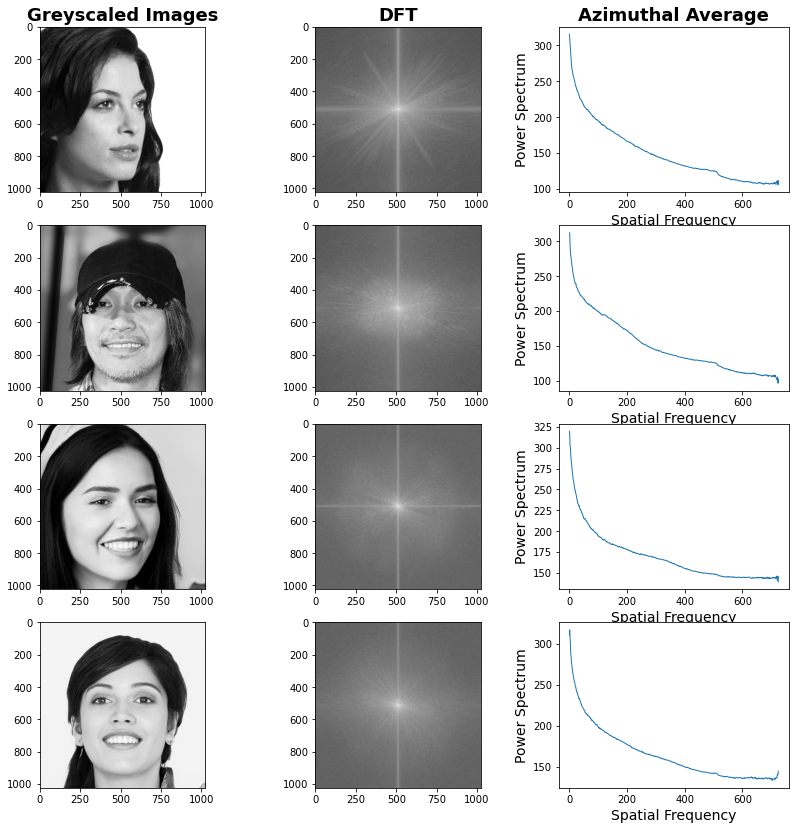

CSV file has been written successfully!
Location: in .ipynb directory

CSV File quick look:

         # Image Name  Classification
0  FutureData\500.jpg            Real
1  FutureData\501.jpg            Real
2  FutureData\502.jpg            Fake
3  FutureData\503.jpg            Fake


In [43]:
_dir = "FutureData/*.jpg"
DeepFakeDetection(_dir,W1[8])